# Convolution vs Attention

- Convolution operation looks like


![img](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/arbitrary_padding_no_strides.gif)

and is 

$$
\text{Output}_{b,c',i,j} = \sum_{c} \sum_{i' = -\Delta}^{\Delta} \sum_{j' = -\Delta}^{\Delta} \mathsf{W}_{c, c', i, j} \, \text{Input}_{b, c, i+i', j+j'},
$$

- Attention operation looks like 

<div style="background: white;">
    <img src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_119_17.png" />
</div>


and is

$$
Attention(Q,K,V) = Softmax(Q K^T / \sqrt{d}) V \in \mathbb{R}^{N \times v}
$$



Refs:
- https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
- http://nlp.seas.harvard.edu/2018/04/03/attention.html



## Toy examples

Let's explore learned convolution kernels vs attention on MNIST

In [1]:
import sys
sys.path.insert(0, "cifar10")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim


from vit import VisionTransformer 


class ConvToyModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(30 * 7 * 7, 10)

    def features(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        return x
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return self.classifier(x)
    
    
def ViTToyModel():
    return VisionTransformer(
        patch_size=2, hidden_size=32, 
        input_channels=1, input_size=28, num_classes=10,
        num_layers=2, num_heads=2, mlp_dim=48,
    )

In [3]:
m = ConvToyModel()
x = torch.rand(4, 1, 28, 28)
y = m(x)
y.shape, sum([m.numel() for m in m.parameters()])

(torch.Size([4, 10]), 22220)

In [4]:
m = ViTToyModel()
x = torch.rand(4, 1, 28, 28)
y = m(x)
y.shape, sum([m.numel() for m in m.parameters()])

(torch.Size([4, 10]), 21898)

In [5]:
import matplotlib.pylab as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Accuracy
from ignite.contrib.handlers import ProgressBar


data_path = "/tmp/mnist"


def get_train_dataloader(data_path, pin_memory=True):
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    train_dataloader = DataLoader(
        MNIST(data_path, train=True, transform=data_transform, download=True),
        batch_size=128,
        num_workers=4,
        shuffle=True,
        pin_memory=pin_memory
    )
    return train_dataloader


def get_test_dataloader(data_path, pin_memory=True):
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    test_dataloader = DataLoader(
        MNIST(data_path, train=False, transform=data_transform),
        batch_size=512,
        num_workers=4,
        shuffle=False,
        pin_memory=pin_memory
    )
    return test_dataloader


def train_and_evaluate(model, device="cuda", weight_getter=None):
    
    train_dataloader = get_train_dataloader(data_path, "cuda" in device)
    test_dataloader = get_test_dataloader(data_path, "cuda" in device)

    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    metrics = {"Accuracy": Accuracy()}
    
    trainer = create_supervised_trainer(model, opt, criterion, device=device)
    evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
    
    ProgressBar().attach(trainer, output_transform=lambda x: {'loss': x})
    
    weights_history = []
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def run_validation():
        epoch = trainer.state.epoch
        train_acc = evaluator.run(train_dataloader).metrics["Accuracy"]
        test_acc = evaluator.run(test_dataloader).metrics["Accuracy"]
        print(f"Epoch {epoch} : Accuracy - train: {train_acc:0.4f}, test: {test_acc:0.4f}")

    if weight_getter is not None:
        @trainer.on(Events.EPOCH_STARTED | Events.COMPLETED)
        def save_weights():
            weights_history.append((trainer.state.epoch, weight_getter(model)))
        
    @trainer.on(Events.COMPLETED)
    def visualize_predictions():
        x, _ = evaluator.state.batch
        y_pred, y = evaluator.state.output
        num_x, num_y = 8, 4
        le = num_x * num_y
        probs, preds = torch.max(torch.softmax(y_pred[:le], dim=1), dim=1)
        fig = plt.figure(figsize=(20, 10))
        for idx in range(le):
            ax = fig.add_subplot(num_y, num_x, idx + 1, xticks=[], yticks=[])
            ax.imshow(x[idx].squeeze(), cmap="Greys")
            ax.set_title("{0} {1:.1f}% (label: {2})".format(
                preds[idx],
                probs[idx] * 100.0,
                y[idx]),
                color=("green" if preds[idx] == y[idx] else "red")
            )

    trainer.run(train_dataloader, max_epochs=10)
    return weights_history

Epoch 1 : Accuracy - train: 0.9786, test: 0.9799


Epoch 2 : Accuracy - train: 0.9839, test: 0.9845


Epoch 3 : Accuracy - train: 0.9894, test: 0.9896


Epoch 4 : Accuracy - train: 0.9908, test: 0.9890


Epoch 5 : Accuracy - train: 0.9902, test: 0.9888


Epoch 6 : Accuracy - train: 0.9940, test: 0.9913


Epoch 7 : Accuracy - train: 0.9940, test: 0.9891


Epoch 8 : Accuracy - train: 0.9954, test: 0.9902


Epoch 9 : Accuracy - train: 0.9953, test: 0.9911


Epoch 10 : Accuracy - train: 0.9970, test: 0.9912


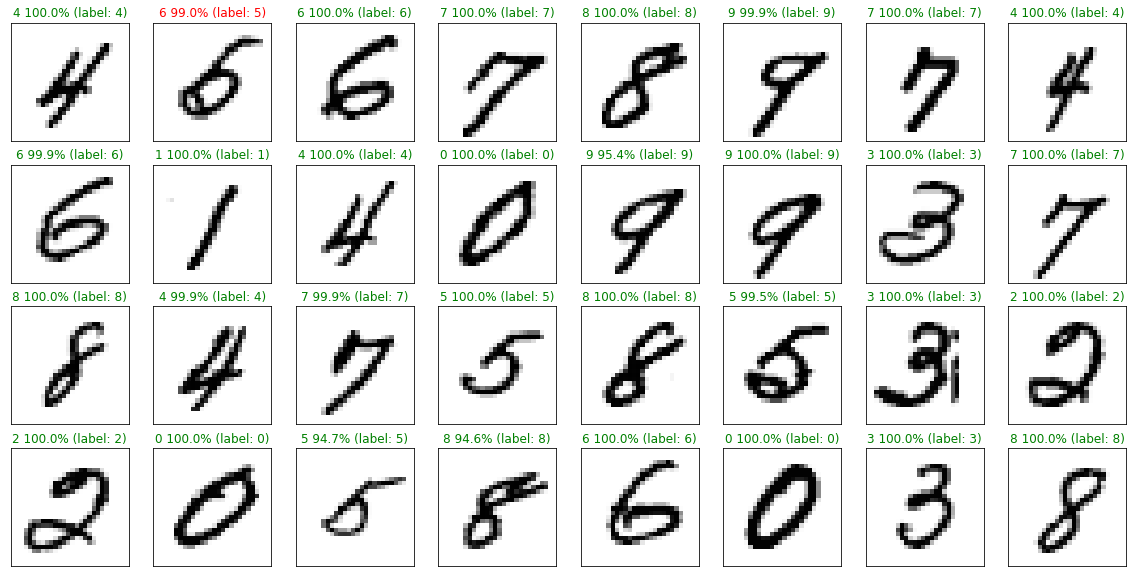

In [31]:
conv_model = ConvToyModel()

def conv_weights_getter(model):
    return model.conv1.weight.detach().cpu().numpy()

conv_weights_history = train_and_evaluate(conv_model, weight_getter=conv_weights_getter)

Epoch 1 : Accuracy - train: 0.5325, test: 0.5240


Epoch 2 : Accuracy - train: 0.7618, test: 0.7654


Epoch 3 : Accuracy - train: 0.8434, test: 0.8500


Epoch 4 : Accuracy - train: 0.8919, test: 0.8956


Epoch 5 : Accuracy - train: 0.9002, test: 0.9029


Epoch 6 : Accuracy - train: 0.9023, test: 0.9061


Epoch 7 : Accuracy - train: 0.9276, test: 0.9268


Epoch 8 : Accuracy - train: 0.9348, test: 0.9363


Epoch 9 : Accuracy - train: 0.9390, test: 0.9390


Epoch 10 : Accuracy - train: 0.9441, test: 0.9434


[]

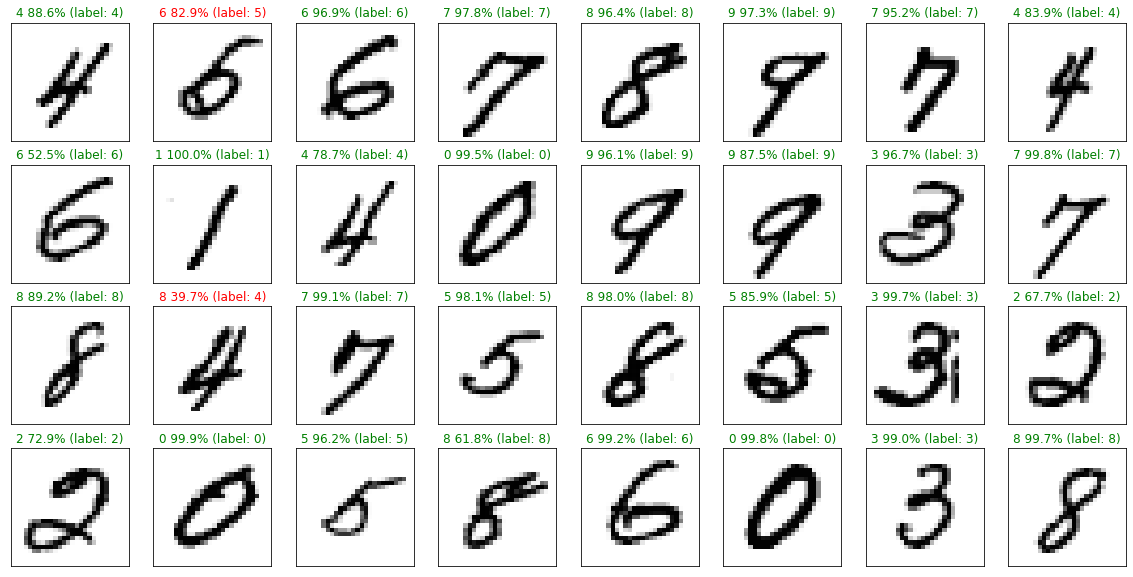

In [6]:
vit_model = ViTToyModel()

train_and_evaluate(vit_model)

### Convolution kernels visualization

In [32]:
def show_conv_kernels(kernels):
    n = 5
    for i in range(min(len(kernels), n * n)):
        if i % n == 0:
            plt.figure(figsize=(20, 2))

        kernel = kernels[i, 0, ...]
        plt.subplot(1, n, (i % n) + 1)
        plt.title(f"Kernel {i}")
        plt.imshow(kernel)
        plt.colorbar()

Conv kernels on epoch 1


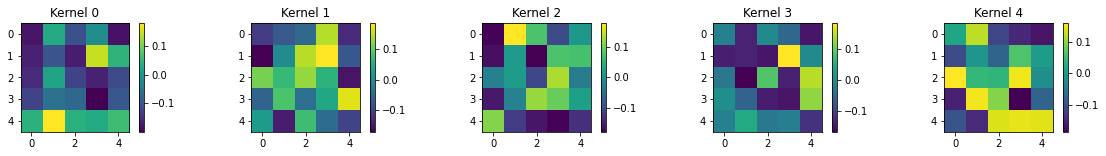

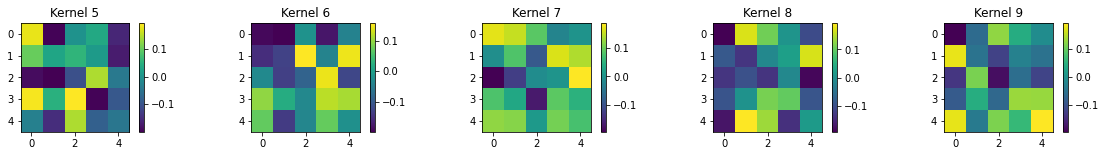

In [33]:
print(f"Conv kernels on epoch {conv_weights_history[0][0]}")
show_conv_kernels(conv_weights_history[0][1])

Conv kernels on epoch 7


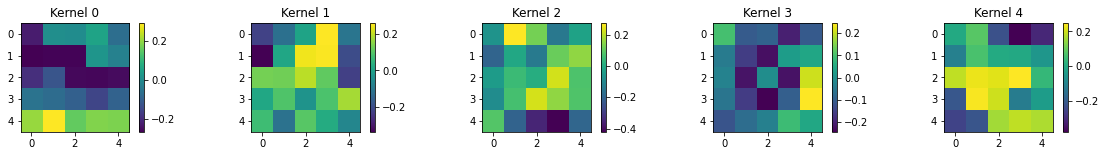

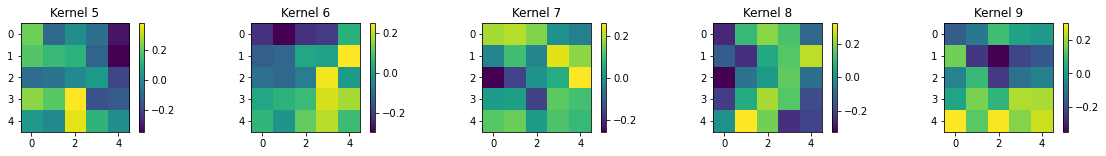

In [34]:
print(f"Conv kernels on epoch {conv_weights_history[-5][0]}")
show_conv_kernels(conv_weights_history[-5][1])

Conv kernels on epoch 10


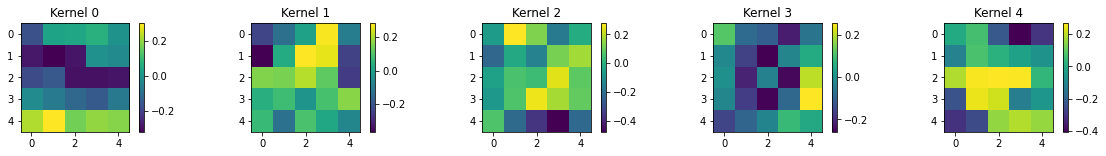

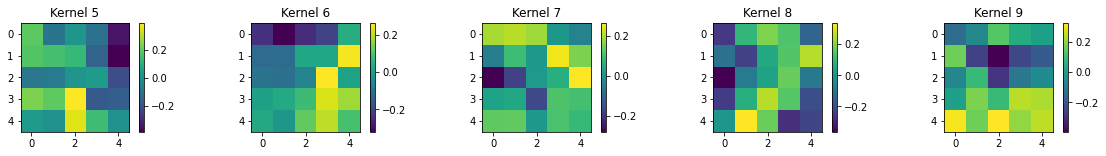

In [35]:
print(f"Conv kernels on epoch {conv_weights_history[-1][0]}")
show_conv_kernels(conv_weights_history[-1][1])

### Activation maps

In [77]:
def show_act_map(images, act_maps, max_n=20, fusion_op="mean"):
    n = 5
    assert len(images) == len(act_maps)
    for i in range(min(len(images), max_n)):
        if i % n == 0:
            plt.figure(figsize=(22, 3))

        plt.subplot(1, 3 * n, 3 * (i % n) + 1)        
        plt.imshow(images[i, ...].permute((1, 2, 0)), cmap="gray")

        plt.subplot(1, 3 * n, 3 * (i % n) + 2)
        plt.title(f"Image + {fusion_op} activation map")
        plt.imshow(images[i, ...].permute((1, 2, 0)), cmap="gray")
        if isinstance(fusion_op, str): 
            fused_act_map = getattr(act_maps[i, ...], fusion_op)(axis=0)
        elif fusion_op is None:
            fused_act_map = act_maps[i, ...]
        else:
            raise ValueError(f"Unknown fusion_op: {fusion_op}")
        plt.imshow(fused_act_map, alpha=0.5, cmap="jet")

        plt.subplot(1, 3 * n, 3 * (i % n) + 3)
        plt.imshow(fused_act_map)

In [57]:
test_loader = get_test_dataloader(data_path, pin_memory=True)
test_batch = next(iter(test_loader))

In [68]:
conv_model.eval()
with torch.no_grad():
    conv_features = conv_model.features(test_batch[0].to("cuda"))
    conv_act_maps = conv_features.cpu()
    conv_act_maps = torch.nn.functional.interpolate(conv_act_maps, size=(28, 28), mode="bilinear", align_corners=False).numpy()
conv_act_maps.shape

(512, 30, 28, 28)

CNN activations map

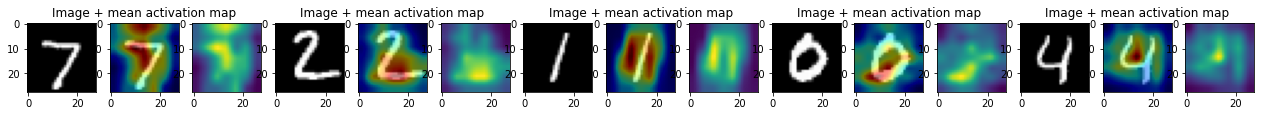

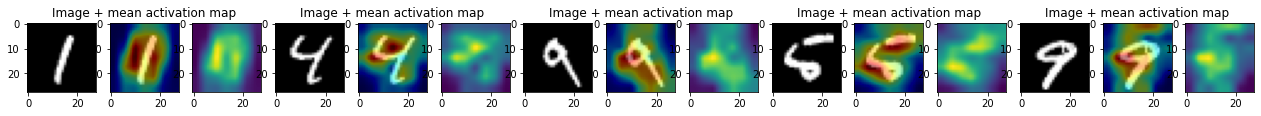

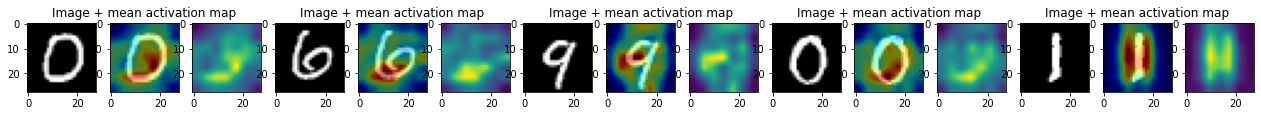

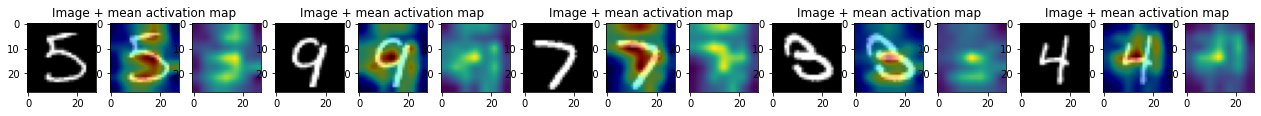

In [69]:
show_act_map(test_batch[0], conv_act_maps, fusion_op="mean")

ViT activations map

In [70]:
vit_model.eval()
with torch.no_grad():
    vit_features = vit_model.features(test_batch[0].to("cuda"))
    vit_act_maps = vit_features.detach().cpu()
    print(vit_act_maps.shape)
    # remove cls token
    vit_act_maps = vit_act_maps[:, 1:, ...].reshape(-1, 14, 14, 32).permute(0, -1, 1, 2)
    vit_act_maps = torch.nn.functional.interpolate(vit_act_maps, size=(28, 28), mode="bilinear", align_corners=False).numpy()
vit_act_maps.shape

torch.Size([512, 197, 32])


(512, 32, 28, 28)

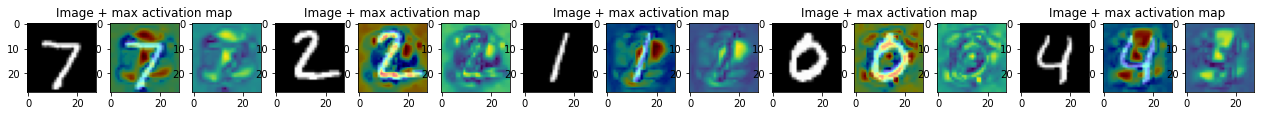

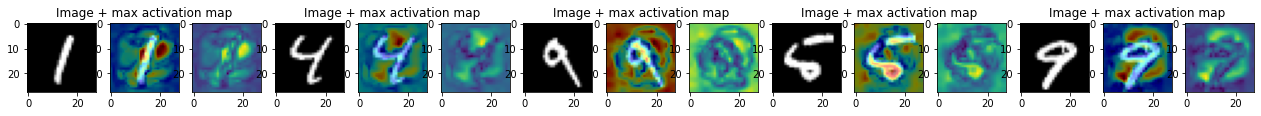

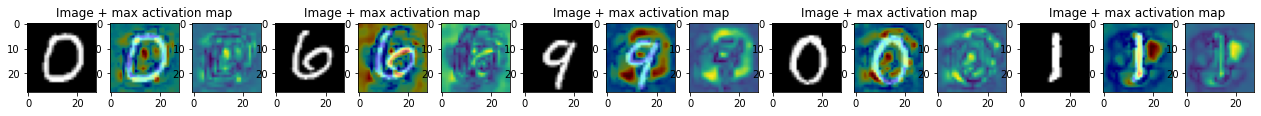

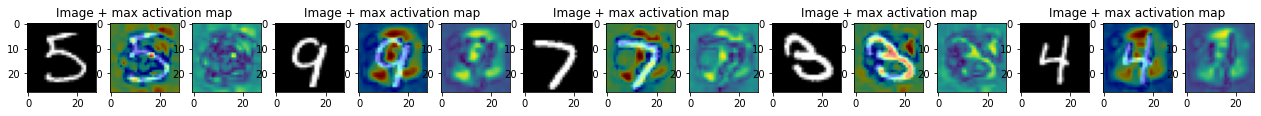

In [71]:
show_act_map(test_batch[0], vit_act_maps, fusion_op="max")

### Attention Rollout

- https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py
- https://jacobgil.github.io/deeplearning/vision-transformer-explainability
- https://github.com/samiraabnar/attention_flow


In the nutshell:

- Each transformer block returns attention matrix `(num_heads, num_tokens, num_tokens)`.
- Attention matrix defines how much "attention" flows from token j in the previous layer to token i in the next layer.
- Residual connection should be taken into account: `(1 + attention_matrix)`
- Total attention is a multiplication of matrices for all blocks

In [63]:
!wget -q https://raw.githubusercontent.com/jacobgil/vit-explain/main/vit_rollout.py

In [72]:
from vit_rollout import VITAttentionRollout

In [73]:
att_rollout = VITAttentionRollout(vit_model, attention_layer_name="att_drop", head_fusion="max")

In [83]:
import cv2
import numpy as np


att_rollout_masks = []
x = test_batch[0].to("cuda")
for i in range(len(x)):
    att_rollout_masks.append(
        cv2.resize(att_rollout(x[i:i + 1, ...]), dsize=(28, 28))
    )
att_rollout_masks = np.stack(att_rollout_masks, axis=0)

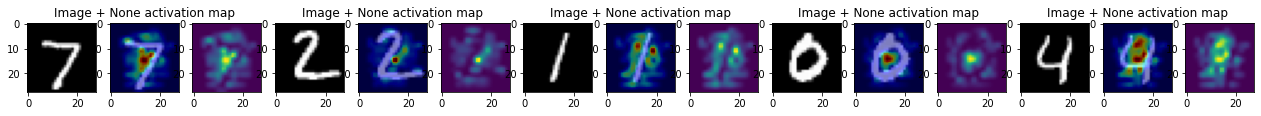

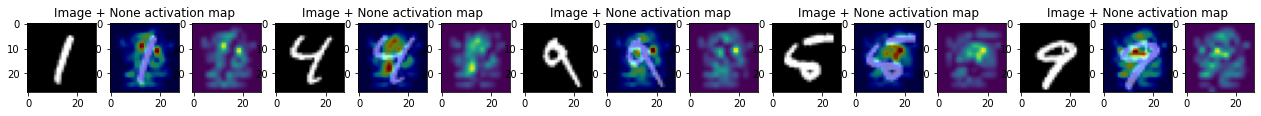

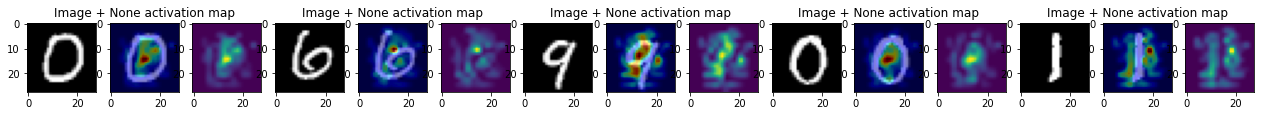

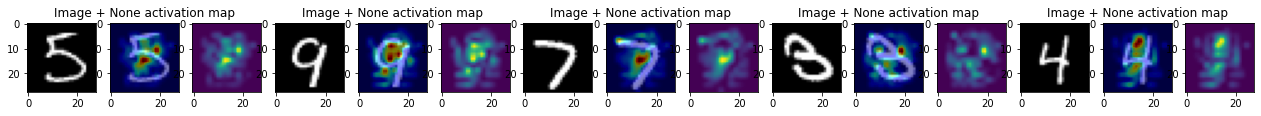

In [84]:
show_act_map(test_batch[0], att_rollout_masks, fusion_op=None)

### Explore attention matrices

In [118]:
vit_model.blocks

Sequential(
  (0): EncoderBlock(
    (lnorm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
    (lnorm2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
    (attention): VisionAttention(
      (qkv): Linear(in_features=32, out_features=96, bias=True)
      (att_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=32, out_features=32, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (mlp): MLP(
      (fc1): Linear(in_features=32, out_features=48, bias=True)
      (gelu): GELU()
      (fc2): Linear(in_features=48, out_features=32, bias=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
  )
  (1): EncoderBlock(
    (lnorm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
    (lnorm2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
    (attention): VisionAttention(
      (qkv): Linear(in_features=32, out_features=96, bias=True)
      (att_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=32, out_features=3

In [109]:
att_rollout(x[0:1, ...]);

In [110]:
# Number of blocks
len(att_rollout.attentions)

2

In [111]:
# Attention matrix for each head
att_rollout.attentions[0].shape

torch.Size([1, 2, 197, 197])

Attention matrix for a single head

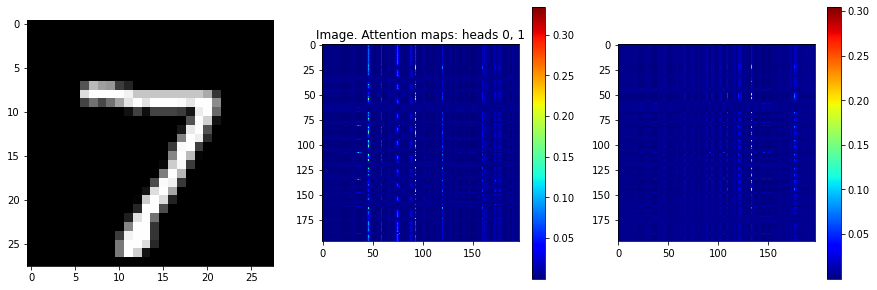

In [112]:
plt.figure(figsize=(15, 5))

img = test_batch[0][0]
att_heads = att_rollout.attentions[0][0, ...]

plt.subplot(1, 3, 1)        
plt.imshow(img.permute((1, 2, 0)), cmap="gray")

plt.subplot(1, 3, 2)
plt.title(f"Image. Attention maps: heads 0, 1")
plt.imshow(att_heads[0], cmap="jet")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(att_heads[1], cmap="jet")
plt.colorbar()

Image token importance for cls token (represented as a table)

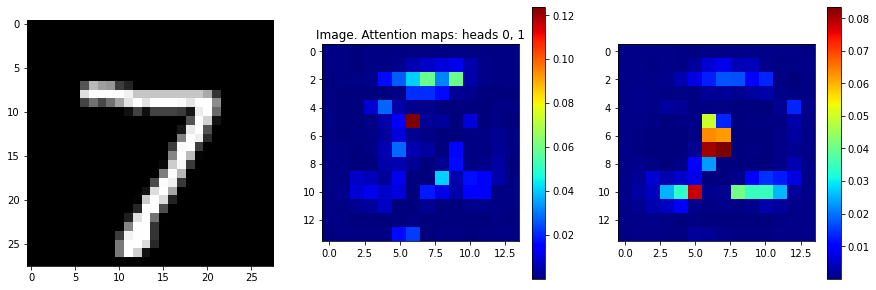

In [115]:
plt.figure(figsize=(15, 5))

img = test_batch[0][0]
att_heads = att_rollout.attentions[0][0, ...]

plt.subplot(1, 3, 1)        
plt.imshow(img.permute((1, 2, 0)), cmap="gray")

plt.subplot(1, 3, 2)
plt.title(f"Image. Attention maps: heads 0, 1")
plt.imshow(att_heads[0][0, 1:].reshape(14, 14), cmap="jet")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(att_heads[1][0, 1:].reshape(14, 14), cmap="jet")
plt.colorbar()

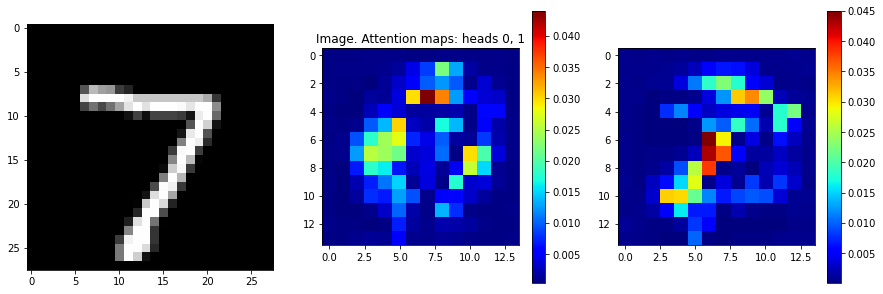

In [116]:
plt.figure(figsize=(15, 5))

img = test_batch[0][0]
att_heads = att_rollout.attentions[1][0, ...]

plt.subplot(1, 3, 1)        
plt.imshow(img.permute((1, 2, 0)), cmap="gray")

plt.subplot(1, 3, 2)
plt.title(f"Image. Attention maps: heads 0, 1")
plt.imshow(att_heads[0][0, 1:].reshape(14, 14), cmap="jet")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(att_heads[1][0, 1:].reshape(14, 14), cmap="jet")
plt.colorbar()